# [PG01] Unsupervised anomaly detection in industrial image data with autoencoders

In this notebook we are going to develop the final projet for the EAI course held by Christian Napoli.

## Imports & Download

In [ ]:
# install the requirements
%pip install -r requirements.txt > /dev/null
# set to false if you already have the dataset
download_dataset = False 
if download_dataset:
    %cd dataset
    !bash dataset/download_dataset.sh
    %cd ..

In [1]:
import dataclasses
from src.data_module import MVTec_Dataset, MVTec_DataModule
from src.AE_simple import AE
from src.hyperparameters import Hparams
from src.train import train_model
from dataclasses import asdict
import matplotlib.pyplot as plt
import wandb
import torchvision
import pytorch_lightning as pl
import gc
# reproducibility stuff
import numpy as np
import random
import torch
np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False
_ = pl.seed_everything(0)
# to have a better workflow using notebook https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
# these commands allow to update the .py codes imported instead of re-importing everything every time.
%load_ext autoreload
%autoreload 2
%env WANDB_NOTEBOOK_NAME = ./anomaly_detection.ipynb
gc.collect()

Global seed set to 0


env: WANDB_NOTEBOOK_NAME=./anomaly_detection.ipynb


30

In [ ]:
# login wandb to have the online logger. It is really useful since it stores all the plots and evolution of the model
# check also https://docs.wandb.ai/guides/integrations/lightning
wandb.login()

## Dataset test

Just to have a visual feedback and test our code, we plot some samples from the training set (only not anomalous samples) and test set (normal and anomalous)

In [ ]:
hparams = asdict(Hparams())

In [ ]:
MVTec_Data = MVTec_DataModule(hparams)
# to setup it takes ~2.5 minutes
MVTec_Data.setup()

In [4]:
# to make sure everything works we just plot a sample of our images
def plot_objects(images, 
                images_per_row, 
                border = 10, 
                pad_value = 1,
                title = 'Industrial images',
                figsize = (16,16)):
    plt.figure(figsize = figsize)
    plt.imshow(torchvision.utils.make_grid(images,images_per_row,border,pad_value=pad_value).permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

In [ ]:
batch = iter(MVTec_Data.train_dataloader()).next()
plot_objects(MVTec_DataModule.denormalize(batch["img"][0:40]), images_per_row=8, title="Industrial images from training dataset")
batch2 = iter(MVTec_Data.val_dataloader()).next()
plot_objects(MVTec_DataModule.denormalize(batch2["img"][0:40]), images_per_row=8, title="Industrial images from validation dataset")

todo some statistics on the pixels of the training dataset to do a proper normalization

## Autoencoders

### CNN-AE l2 deterministic

In [2]:
# settings for the logger working in a team
team_name = "eai_project"
project_name = "EAI_Anomaly_Detection"
# to edit 
version_name = "Simple_AE_04"
run = wandb.init(entity=team_name, project=project_name, name = version_name, mode = "offline")

ae_hparams = asdict(Hparams())
data = MVTec_DataModule(ae_hparams)
model = AE(ae_hparams)
trainer = train_model(data,model, experiment_name = version_name, patience=20, metric_to_monitor="accuracy", mode="max", epochs = 150)

wandb.finish()

wandb: ERROR Failed to sample metric: Not Supported


/home/dennis/Applications/anaconda3/envs/dlp/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dennis/Applications/anaconda3/envs/dlp/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/dennis/Desktop/eai_anomaly_detection/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | encoder | Encoder  | 11.3 M
1 | decoder | Decoder  | 13.3 M
2 | val_acc | Accuracy | 0     
-

Epoch 0: 100%|██████████| 22/22 [00:19<00:00,  1.13it/s, loss=2.88e+03, v_num=pty2, accuracy=0.729]

Metric accuracy improved. New best score: 0.729


Epoch 0: 100%|██████████| 22/22 [00:19<00:00,  1.13it/s, loss=2.88e+03, v_num=pty2, accuracy=0.729, anomaly_threshold=1.14e+5]

Epoch 0, global step 15: 'accuracy' reached 0.72928 (best 0.72928), saving model to '/home/dennis/Desktop/eai_anomaly_detection/models/Simple_AE_04-epoch=00-accuracy=0.7293-v7.ckpt' as top 1


Epoch 1: 100%|██████████| 22/22 [00:08<00:00,  2.60it/s, loss=2.27e+03, v_num=pty2, accuracy=0.645, anomaly_threshold=7.97e+4]

Epoch 1, global step 30: 'accuracy' was not in top 1


Epoch 2: 100%|██████████| 22/22 [00:08<00:00,  2.53it/s, loss=2.01e+03, v_num=pty2, accuracy=0.577, anomaly_threshold=7.45e+4]

Epoch 2, global step 45: 'accuracy' was not in top 1


Epoch 3: 100%|██████████| 22/22 [00:08<00:00,  2.54it/s, loss=1.8e+03, v_num=pty2, accuracy=0.577, anomaly_threshold=7.01e+4] 

Epoch 3, global step 60: 'accuracy' was not in top 1


Epoch 4: 100%|██████████| 22/22 [00:09<00:00,  2.42it/s, loss=1.65e+03, v_num=pty2, accuracy=0.626, anomaly_threshold=6.81e+4]

Epoch 4, global step 75: 'accuracy' was not in top 1


Epoch 5: 100%|██████████| 22/22 [00:08<00:00,  2.45it/s, loss=1.5e+03, v_num=pty2, accuracy=0.674, anomaly_threshold=6.46e+4] 

Epoch 5, global step 90: 'accuracy' was not in top 1


Epoch 6: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=1.28e+03, v_num=pty2, accuracy=0.596, anomaly_threshold=5.99e+4]

Epoch 6, global step 105: 'accuracy' was not in top 1


Epoch 7: 100%|██████████| 22/22 [00:09<00:00,  2.42it/s, loss=986, v_num=pty2, accuracy=0.725, anomaly_threshold=4.97e+4]     

Epoch 7, global step 120: 'accuracy' was not in top 1


Epoch 8: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, loss=807, v_num=pty2, accuracy=0.699, anomaly_threshold=4.41e+4]

Epoch 8, global step 135: 'accuracy' was not in top 1


Epoch 9: 100%|██████████| 22/22 [00:08<00:00,  2.45it/s, loss=703, v_num=pty2, accuracy=0.690, anomaly_threshold=4.07e+4]

Epoch 9, global step 150: 'accuracy' was not in top 1


Epoch 10: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=637, v_num=pty2, accuracy=0.687, anomaly_threshold=3.93e+4]

Epoch 10, global step 165: 'accuracy' was not in top 1


Epoch 11: 100%|██████████| 22/22 [00:08<00:00,  2.48it/s, loss=598, v_num=pty2, accuracy=0.645, anomaly_threshold=3.66e+4]

Epoch 11, global step 180: 'accuracy' was not in top 1


Epoch 12: 100%|██████████| 22/22 [00:08<00:00,  2.45it/s, loss=550, v_num=pty2, accuracy=0.563, anomaly_threshold=3.55e+4]

Epoch 12, global step 195: 'accuracy' was not in top 1


Epoch 13: 100%|██████████| 22/22 [00:08<00:00,  2.45it/s, loss=528, v_num=pty2, accuracy=0.666, anomaly_threshold=3.41e+4]

Epoch 13, global step 210: 'accuracy' was not in top 1


Epoch 14: 100%|██████████| 22/22 [00:09<00:00,  2.42it/s, loss=498, v_num=pty2, accuracy=0.668, anomaly_threshold=3.32e+4]

Epoch 14, global step 225: 'accuracy' was not in top 1


Epoch 15: 100%|██████████| 22/22 [00:08<00:00,  2.46it/s, loss=504, v_num=pty2, accuracy=0.598, anomaly_threshold=4.04e+4]

Epoch 15, global step 240: 'accuracy' was not in top 1


Epoch 16: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=502, v_num=pty2, accuracy=0.689, anomaly_threshold=3.4e+4] 

Epoch 16, global step 255: 'accuracy' was not in top 1


Epoch 17: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, loss=463, v_num=pty2, accuracy=0.666, anomaly_threshold=3.3e+4]

Epoch 17, global step 270: 'accuracy' was not in top 1


Epoch 18: 100%|██████████| 22/22 [00:09<00:00,  2.44it/s, loss=451, v_num=pty2, accuracy=0.589, anomaly_threshold=3.43e+4]

Epoch 18, global step 285: 'accuracy' was not in top 1


Epoch 19: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, loss=443, v_num=pty2, accuracy=0.671, anomaly_threshold=3.19e+4]

Epoch 19, global step 300: 'accuracy' was not in top 1


Epoch 20: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, loss=394, v_num=pty2, accuracy=0.639, anomaly_threshold=3.19e+4]

Monitored metric accuracy did not improve in the last 20 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 20: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, loss=394, v_num=pty2, accuracy=0.639, anomaly_threshold=3e+4]   

Epoch 20, global step 315: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 21: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=360, v_num=pty2, accuracy=0.630, anomaly_threshold=3e+4]

Monitored metric accuracy did not improve in the last 21 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 21: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=360, v_num=pty2, accuracy=0.630, anomaly_threshold=2.79e+4]

Epoch 21, global step 330: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 22: 100%|██████████| 22/22 [00:08<00:00,  2.45it/s, loss=350, v_num=pty2, accuracy=0.618, anomaly_threshold=2.79e+4]

Monitored metric accuracy did not improve in the last 22 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 22: 100%|██████████| 22/22 [00:08<00:00,  2.45it/s, loss=350, v_num=pty2, accuracy=0.618, anomaly_threshold=2.71e+4]

Epoch 22, global step 345: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 23: 100%|██████████| 22/22 [00:09<00:00,  2.37it/s, loss=344, v_num=pty2, accuracy=0.605, anomaly_threshold=2.71e+4]

Monitored metric accuracy did not improve in the last 23 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 23: 100%|██████████| 22/22 [00:09<00:00,  2.37it/s, loss=344, v_num=pty2, accuracy=0.605, anomaly_threshold=2.97e+4]

Epoch 23, global step 360: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 24: 100%|██████████| 22/22 [00:08<00:00,  2.45it/s, loss=342, v_num=pty2, accuracy=0.630, anomaly_threshold=2.97e+4]

Monitored metric accuracy did not improve in the last 24 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 24: 100%|██████████| 22/22 [00:08<00:00,  2.44it/s, loss=342, v_num=pty2, accuracy=0.630, anomaly_threshold=2.71e+4]

Epoch 24, global step 375: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 25: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s, loss=329, v_num=pty2, accuracy=0.619, anomaly_threshold=2.71e+4]

Monitored metric accuracy did not improve in the last 25 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 25: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s, loss=329, v_num=pty2, accuracy=0.619, anomaly_threshold=2.74e+4]

Epoch 25, global step 390: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 26: 100%|██████████| 22/22 [00:08<00:00,  2.47it/s, loss=324, v_num=pty2, accuracy=0.570, anomaly_threshold=2.74e+4]

Monitored metric accuracy did not improve in the last 26 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 22/22 [00:08<00:00,  2.47it/s, loss=324, v_num=pty2, accuracy=0.570, anomaly_threshold=2.59e+4]

Epoch 26, global step 405: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 27: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=319, v_num=pty2, accuracy=0.524, anomaly_threshold=2.59e+4]

Monitored metric accuracy did not improve in the last 27 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 27: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=319, v_num=pty2, accuracy=0.524, anomaly_threshold=2.53e+4]

Epoch 27, global step 420: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 28: 100%|██████████| 22/22 [00:08<00:00,  2.58it/s, loss=320, v_num=pty2, accuracy=0.616, anomaly_threshold=2.53e+4]

Monitored metric accuracy did not improve in the last 28 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 28: 100%|██████████| 22/22 [00:08<00:00,  2.57it/s, loss=320, v_num=pty2, accuracy=0.616, anomaly_threshold=2.78e+4]

Epoch 28, global step 435: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 29: 100%|██████████| 22/22 [00:09<00:00,  2.42it/s, loss=320, v_num=pty2, accuracy=0.616, anomaly_threshold=2.78e+4]

Monitored metric accuracy did not improve in the last 29 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 29: 100%|██████████| 22/22 [00:09<00:00,  2.42it/s, loss=320, v_num=pty2, accuracy=0.616, anomaly_threshold=2.51e+4]

Epoch 29, global step 450: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 30: 100%|██████████| 22/22 [00:09<00:00,  2.36it/s, loss=311, v_num=pty2, accuracy=0.617, anomaly_threshold=2.51e+4]

Monitored metric accuracy did not improve in the last 30 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 30: 100%|██████████| 22/22 [00:09<00:00,  2.36it/s, loss=311, v_num=pty2, accuracy=0.617, anomaly_threshold=2.66e+4]

Epoch 30, global step 465: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 31: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=304, v_num=pty2, accuracy=0.619, anomaly_threshold=2.66e+4]

Monitored metric accuracy did not improve in the last 31 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 31: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=304, v_num=pty2, accuracy=0.619, anomaly_threshold=2.42e+4]

Epoch 31, global step 480: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 32: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, loss=304, v_num=pty2, accuracy=0.616, anomaly_threshold=2.42e+4]

Monitored metric accuracy did not improve in the last 32 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 32: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, loss=304, v_num=pty2, accuracy=0.616, anomaly_threshold=2.47e+4]

Epoch 32, global step 495: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 33: 100%|██████████| 22/22 [00:08<00:00,  2.46it/s, loss=305, v_num=pty2, accuracy=0.616, anomaly_threshold=2.47e+4]

Monitored metric accuracy did not improve in the last 33 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 33: 100%|██████████| 22/22 [00:08<00:00,  2.46it/s, loss=305, v_num=pty2, accuracy=0.616, anomaly_threshold=2.74e+4]

Epoch 33, global step 510: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 34: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, loss=309, v_num=pty2, accuracy=0.619, anomaly_threshold=2.74e+4]

Monitored metric accuracy did not improve in the last 34 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 34: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, loss=309, v_num=pty2, accuracy=0.619, anomaly_threshold=2.48e+4]

Epoch 34, global step 525: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 35: 100%|██████████| 22/22 [00:09<00:00,  2.36it/s, loss=311, v_num=pty2, accuracy=0.610, anomaly_threshold=2.48e+4]

Monitored metric accuracy did not improve in the last 35 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 35: 100%|██████████| 22/22 [00:09<00:00,  2.36it/s, loss=311, v_num=pty2, accuracy=0.610, anomaly_threshold=3.03e+4]

Epoch 35, global step 540: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 36: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=315, v_num=pty2, accuracy=0.645, anomaly_threshold=3.03e+4]

Monitored metric accuracy did not improve in the last 36 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 36: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=315, v_num=pty2, accuracy=0.645, anomaly_threshold=2.62e+4]

Epoch 36, global step 555: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 37: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=298, v_num=pty2, accuracy=0.616, anomaly_threshold=2.62e+4]

Monitored metric accuracy did not improve in the last 37 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 37: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=298, v_num=pty2, accuracy=0.616, anomaly_threshold=2.45e+4]

Epoch 37, global step 570: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 38: 100%|██████████| 22/22 [00:09<00:00,  2.42it/s, loss=298, v_num=pty2, accuracy=0.620, anomaly_threshold=2.45e+4]

Monitored metric accuracy did not improve in the last 38 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 38: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s, loss=298, v_num=pty2, accuracy=0.620, anomaly_threshold=2.61e+4]

Epoch 38, global step 585: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch    39: reducing learning rate of group 0 to 1.0000e-04.
Epoch 39: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, loss=289, v_num=pty2, accuracy=0.618, anomaly_threshold=2.61e+4]

Monitored metric accuracy did not improve in the last 39 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 39: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s, loss=289, v_num=pty2, accuracy=0.618, anomaly_threshold=2.66e+4]

Epoch 39, global step 600: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 40: 100%|██████████| 22/22 [00:09<00:00,  2.36it/s, loss=286, v_num=pty2, accuracy=0.619, anomaly_threshold=2.66e+4]

Monitored metric accuracy did not improve in the last 40 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 40: 100%|██████████| 22/22 [00:09<00:00,  2.36it/s, loss=286, v_num=pty2, accuracy=0.619, anomaly_threshold=2.48e+4]

Epoch 40, global step 615: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 41: 100%|██████████| 22/22 [00:09<00:00,  2.34it/s, loss=286, v_num=pty2, accuracy=0.619, anomaly_threshold=2.48e+4]

Monitored metric accuracy did not improve in the last 41 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 41: 100%|██████████| 22/22 [00:09<00:00,  2.34it/s, loss=286, v_num=pty2, accuracy=0.619, anomaly_threshold=2.44e+4]

Epoch 41, global step 630: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 42: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=282, v_num=pty2, accuracy=0.619, anomaly_threshold=2.44e+4]

Monitored metric accuracy did not improve in the last 42 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 42: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=282, v_num=pty2, accuracy=0.619, anomaly_threshold=2.34e+4]

Epoch 42, global step 645: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 43: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=281, v_num=pty2, accuracy=0.617, anomaly_threshold=2.34e+4]

Monitored metric accuracy did not improve in the last 43 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 43: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=281, v_num=pty2, accuracy=0.617, anomaly_threshold=2.28e+4]

Epoch 43, global step 660: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 44: 100%|██████████| 22/22 [00:09<00:00,  2.35it/s, loss=284, v_num=pty2, accuracy=0.614, anomaly_threshold=2.28e+4]

Monitored metric accuracy did not improve in the last 44 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 44: 100%|██████████| 22/22 [00:09<00:00,  2.34it/s, loss=284, v_num=pty2, accuracy=0.614, anomaly_threshold=2.28e+4]

Epoch 44, global step 675: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 45: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=287, v_num=pty2, accuracy=0.613, anomaly_threshold=2.28e+4]

Monitored metric accuracy did not improve in the last 45 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 45: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=287, v_num=pty2, accuracy=0.613, anomaly_threshold=3.04e+4]

Epoch 45, global step 690: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 46: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=288, v_num=pty2, accuracy=0.648, anomaly_threshold=3.04e+4]

Monitored metric accuracy did not improve in the last 46 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 46: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=288, v_num=pty2, accuracy=0.648, anomaly_threshold=2.4e+4] 

Epoch 46, global step 705: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 47: 100%|██████████| 22/22 [00:09<00:00,  2.35it/s, loss=277, v_num=pty2, accuracy=0.618, anomaly_threshold=2.4e+4]

Monitored metric accuracy did not improve in the last 47 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 47: 100%|██████████| 22/22 [00:09<00:00,  2.35it/s, loss=277, v_num=pty2, accuracy=0.618, anomaly_threshold=2.53e+4]

Epoch 47, global step 720: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 48: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=283, v_num=pty2, accuracy=0.619, anomaly_threshold=2.53e+4]

Monitored metric accuracy did not improve in the last 48 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 48: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=283, v_num=pty2, accuracy=0.619, anomaly_threshold=2.29e+4]

Epoch 48, global step 735: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 49: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=282, v_num=pty2, accuracy=0.615, anomaly_threshold=2.29e+4]

Monitored metric accuracy did not improve in the last 49 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 49: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=282, v_num=pty2, accuracy=0.615, anomaly_threshold=2.32e+4]

Epoch 49, global step 750: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 50: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, loss=284, v_num=pty2, accuracy=0.618, anomaly_threshold=2.32e+4]

Monitored metric accuracy did not improve in the last 50 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 50: 100%|██████████| 22/22 [00:09<00:00,  2.43it/s, loss=284, v_num=pty2, accuracy=0.618, anomaly_threshold=2.35e+4]

Epoch 50, global step 765: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 51: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=282, v_num=pty2, accuracy=0.617, anomaly_threshold=2.35e+4]

Monitored metric accuracy did not improve in the last 51 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 51: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=282, v_num=pty2, accuracy=0.617, anomaly_threshold=2.39e+4]

Epoch 51, global step 780: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 52: 100%|██████████| 22/22 [00:08<00:00,  2.46it/s, loss=279, v_num=pty2, accuracy=0.619, anomaly_threshold=2.39e+4]

Monitored metric accuracy did not improve in the last 52 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 52: 100%|██████████| 22/22 [00:08<00:00,  2.46it/s, loss=279, v_num=pty2, accuracy=0.619, anomaly_threshold=2.36e+4]

Epoch 52, global step 795: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 53: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s, loss=278, v_num=pty2, accuracy=0.617, anomaly_threshold=2.36e+4]

Monitored metric accuracy did not improve in the last 53 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 53: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s, loss=278, v_num=pty2, accuracy=0.617, anomaly_threshold=2.45e+4]

Epoch 53, global step 810: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 54: 100%|██████████| 22/22 [00:09<00:00,  2.36it/s, loss=284, v_num=pty2, accuracy=0.619, anomaly_threshold=2.45e+4]

Monitored metric accuracy did not improve in the last 54 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 54: 100%|██████████| 22/22 [00:09<00:00,  2.36it/s, loss=284, v_num=pty2, accuracy=0.619, anomaly_threshold=2.83e+4]

Epoch 54, global step 825: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 55: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=284, v_num=pty2, accuracy=0.620, anomaly_threshold=2.83e+4]

Monitored metric accuracy did not improve in the last 55 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 55: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=284, v_num=pty2, accuracy=0.620, anomaly_threshold=2.3e+4] 

Epoch 55, global step 840: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 56: 100%|██████████| 22/22 [00:09<00:00,  2.42it/s, loss=279, v_num=pty2, accuracy=0.613, anomaly_threshold=2.3e+4]

Monitored metric accuracy did not improve in the last 56 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 56: 100%|██████████| 22/22 [00:09<00:00,  2.42it/s, loss=279, v_num=pty2, accuracy=0.613, anomaly_threshold=2.47e+4]

Epoch 56, global step 855: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 57: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s, loss=283, v_num=pty2, accuracy=0.619, anomaly_threshold=2.47e+4]

Monitored metric accuracy did not improve in the last 57 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 57: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s, loss=283, v_num=pty2, accuracy=0.619, anomaly_threshold=2.65e+4]

Epoch 57, global step 870: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch    58: reducing learning rate of group 0 to 1.0000e-05.
Epoch 58: 100%|██████████| 22/22 [00:09<00:00,  2.34it/s, loss=281, v_num=pty2, accuracy=0.618, anomaly_threshold=2.65e+4]

Monitored metric accuracy did not improve in the last 58 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 58: 100%|██████████| 22/22 [00:09<00:00,  2.34it/s, loss=281, v_num=pty2, accuracy=0.618, anomaly_threshold=2.29e+4]

Epoch 58, global step 885: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 59: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=278, v_num=pty2, accuracy=0.616, anomaly_threshold=2.29e+4]

Monitored metric accuracy did not improve in the last 59 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 59: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=278, v_num=pty2, accuracy=0.616, anomaly_threshold=2.24e+4]

Epoch 59, global step 900: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 60: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=277, v_num=pty2, accuracy=0.613, anomaly_threshold=2.24e+4]

Monitored metric accuracy did not improve in the last 60 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 60: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=277, v_num=pty2, accuracy=0.613, anomaly_threshold=2.54e+4]

Epoch 60, global step 915: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 61: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=280, v_num=pty2, accuracy=0.618, anomaly_threshold=2.54e+4]

Monitored metric accuracy did not improve in the last 61 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 61: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=280, v_num=pty2, accuracy=0.618, anomaly_threshold=2.34e+4]

Epoch 61, global step 930: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 62: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=274, v_num=pty2, accuracy=0.617, anomaly_threshold=2.34e+4]

Monitored metric accuracy did not improve in the last 62 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 62: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=274, v_num=pty2, accuracy=0.617, anomaly_threshold=2.2e+4] 

Epoch 62, global step 945: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 63: 100%|██████████| 22/22 [00:09<00:00,  2.37it/s, loss=277, v_num=pty2, accuracy=0.613, anomaly_threshold=2.2e+4]

Monitored metric accuracy did not improve in the last 63 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 63: 100%|██████████| 22/22 [00:09<00:00,  2.37it/s, loss=277, v_num=pty2, accuracy=0.613, anomaly_threshold=2.63e+4]

Epoch 63, global step 960: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 64: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=279, v_num=pty2, accuracy=0.620, anomaly_threshold=2.63e+4]

Monitored metric accuracy did not improve in the last 64 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 64: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=279, v_num=pty2, accuracy=0.620, anomaly_threshold=2.33e+4]

Epoch 64, global step 975: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 65: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=280, v_num=pty2, accuracy=0.617, anomaly_threshold=2.33e+4]

Monitored metric accuracy did not improve in the last 65 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 65: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=280, v_num=pty2, accuracy=0.617, anomaly_threshold=2.57e+4]

Epoch 65, global step 990: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 66: 100%|██████████| 22/22 [00:09<00:00,  2.34it/s, loss=281, v_num=pty2, accuracy=0.617, anomaly_threshold=2.57e+4]

Monitored metric accuracy did not improve in the last 66 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 66: 100%|██████████| 22/22 [00:09<00:00,  2.34it/s, loss=281, v_num=pty2, accuracy=0.617, anomaly_threshold=2.41e+4]

Epoch 66, global step 1005: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 67: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=279, v_num=pty2, accuracy=0.620, anomaly_threshold=2.41e+4]

Monitored metric accuracy did not improve in the last 67 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 67: 100%|██████████| 22/22 [00:09<00:00,  2.40it/s, loss=279, v_num=pty2, accuracy=0.620, anomaly_threshold=2.44e+4]

Epoch 67, global step 1020: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 68: 100%|██████████| 22/22 [00:09<00:00,  2.37it/s, loss=276, v_num=pty2, accuracy=0.619, anomaly_threshold=2.44e+4]

Monitored metric accuracy did not improve in the last 68 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 68: 100%|██████████| 22/22 [00:09<00:00,  2.36it/s, loss=276, v_num=pty2, accuracy=0.619, anomaly_threshold=2.27e+4]

Epoch 68, global step 1035: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch    69: reducing learning rate of group 0 to 1.0000e-06.
Epoch 69: 100%|██████████| 22/22 [00:08<00:00,  2.46it/s, loss=276, v_num=pty2, accuracy=0.614, anomaly_threshold=2.27e+4]

Monitored metric accuracy did not improve in the last 69 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 69: 100%|██████████| 22/22 [00:08<00:00,  2.45it/s, loss=276, v_num=pty2, accuracy=0.614, anomaly_threshold=2.3e+4] 

Epoch 69, global step 1050: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 70: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s, loss=275, v_num=pty2, accuracy=0.616, anomaly_threshold=2.3e+4]

Monitored metric accuracy did not improve in the last 70 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 70: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s, loss=275, v_num=pty2, accuracy=0.616, anomaly_threshold=2.23e+4]

Epoch 70, global step 1065: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 71: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=274, v_num=pty2, accuracy=0.614, anomaly_threshold=2.23e+4]

Monitored metric accuracy did not improve in the last 71 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 71: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=274, v_num=pty2, accuracy=0.614, anomaly_threshold=2.37e+4]

Epoch 71, global step 1080: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 72: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=276, v_num=pty2, accuracy=0.619, anomaly_threshold=2.37e+4]

Monitored metric accuracy did not improve in the last 72 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 72: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s, loss=276, v_num=pty2, accuracy=0.619, anomaly_threshold=2.21e+4]

Epoch 72, global step 1095: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 73: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s, loss=275, v_num=pty2, accuracy=0.614, anomaly_threshold=2.21e+4]

Monitored metric accuracy did not improve in the last 73 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 73: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s, loss=275, v_num=pty2, accuracy=0.614, anomaly_threshold=2.34e+4]

Epoch 73, global step 1110: 'accuracy' was not in top 1
Trainer was signaled to stop but required minimum epochs (75.0) or minimum steps (None) has not been met. Training will continue...


Epoch 74: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=270, v_num=pty2, accuracy=0.617, anomaly_threshold=2.34e+4]

Monitored metric accuracy did not improve in the last 74 records. Best score: 0.729. Signaling Trainer to stop.


Epoch 74: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=270, v_num=pty2, accuracy=0.617, anomaly_threshold=2.22e+4]

Epoch 74, global step 1125: 'accuracy' was not in top 1


Epoch 74: 100%|██████████| 22/22 [00:09<00:00,  2.39it/s, loss=270, v_num=pty2, accuracy=0.617, anomaly_threshold=2.22e+4]


accuracy,█▄▁▆█▆▄▅▂▅▂▄▃▄▁▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
anomaly_threshold,█▅▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_anomaly_score,█▆▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▆▄▃▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_anomaly_score,█▅▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
accuracy,0.61681
anomaly_threshold,22151.92969
avg_anomaly_score,21046.11523
epoch,75


In [ ]:
best_ckpt = "models/Simple_AE_01-epoch=71-avg_val_loss=0.0278.ckpt"
model_best = AE.load_from_checkpoint(best_ckpt, strict=False)

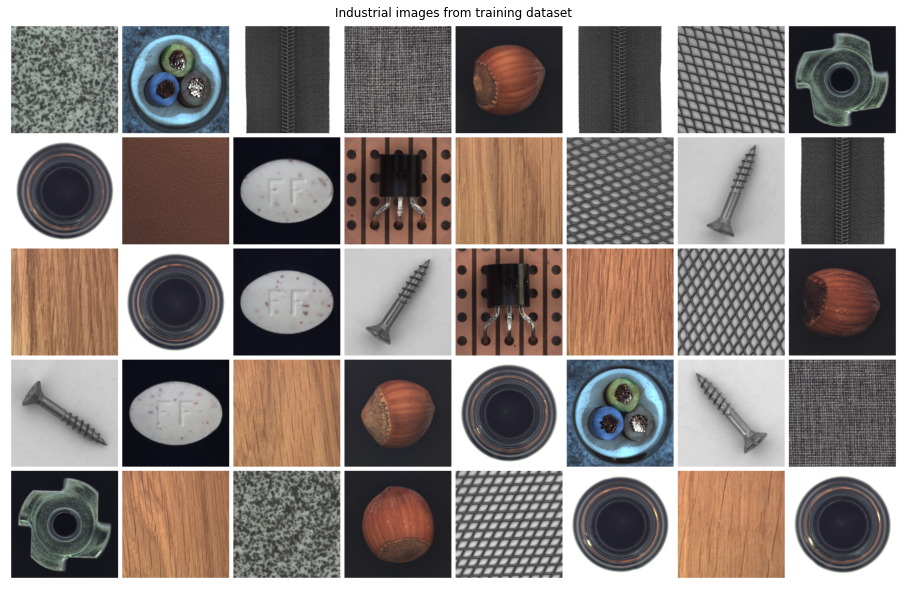

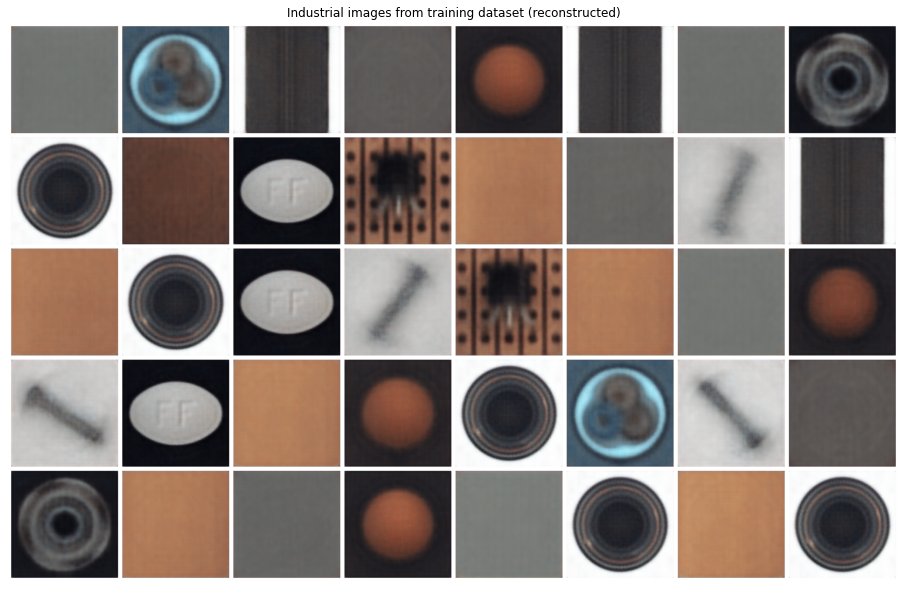

In [10]:
batch = iter(data.train_dataloader()).next()
plot_objects(MVTec_DataModule.denormalize(batch["img"][0:40]), images_per_row=8, title="Industrial images from training dataset")

batch_recon = model(batch["img"])
plot_objects(MVTec_DataModule.denormalize(batch_recon[0:40]), images_per_row=8, title="Industrial images from training dataset (reconstructed)")